In [1]:
import cv2
import math
import numpy as np
from numpy import random
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import urllib.request
import os
%matplotlib inline

In [2]:
def euc(pt_1, pt_2):
    return np.sqrt( (pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2 )

In [3]:
def get_card_contour(image, min_p = 4, max_p = 400, min_a = 1000, max_a = 20000):
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresholdImage = cv2.threshold(imageGray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    morphImage = cv2.morphologyEx(thresholdImage, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    cardContours, _ = cv2.findContours(morphImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cardContours = [ contour for contour in cardContours
                if len(contour) >= min_p and
                len(contour) <= max_p and
                cv2.contourArea(contour) > min_a and
                cv2.contourArea(contour) < max_a]
    return cardContours

In [4]:
def mark_card_corner(cardContours):
    result = []
    for contour in cardContours:
        convex = cv2.convexHull(contour) # should be card contour
        eps = 0.1*cv2.arcLength(convex, True)
        approximate_hull = cv2.approxPolyDP(convex, eps, True)
        if approximate_hull.shape[0] != 4:
            continue
        approximate_hull = np.reshape(approximate_hull, (4,2))
        result.append(approximate_hull)
    return result

In [5]:
def crop_cards(cardCorners, inputImage):
    result = []
    for corner in cardCorners:
        point_A = corner[0]
        point_B = corner[3]
        point_C = corner[2]
        point_D = corner[1]

        AD = euc(point_A, point_D)
        BC = euc(point_B, point_C)
        AB = euc(point_A, point_B)
        CD = euc(point_C, point_D)

        maxWidth = max(int(AD), int(BC))
        maxHeight = max(int(AB), int(CD))

        input_points = np.float32([point_A,point_B,point_C,point_D])
        output_points = np.float32([(0,0), (0, maxHeight-1), (maxWidth-1, maxHeight-1), (maxWidth-1, 0)])

        # transform card to axis-aligned rectangle
        transform = cv2.getPerspectiveTransform(input_points, output_points)
        output = cv2.warpPerspective(inputImage.copy(), transform, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

        # rotate card
        if output.shape[0] < output.shape[1]:
            output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
            
        # resize card
        output = cv2.resize(output, (80, 100), interpolation=cv2.INTER_AREA)
        result.append(output)

    return result
    

In [6]:
# def crop_cards(cardContours, inputImage):
#     result = []
#     for contour in cardContours:
#         convex = cv2.convexHull(contour) # should be card contour
#         eps = 0.1*cv2.arcLength(convex, True)
#         approximate_hull = cv2.approxPolyDP(convex, eps, True)
#         # print('bef:', approximate_hull.shape)
#         if approximate_hull.shape[0] != 4:
#             continue
#         approximate_hull = np.reshape(approximate_hull, (4,2))
#         # print('aft:', approximate_hull.shape)
#         # print(approximate_hull)

#         point_A = approximate_hull[0]
#         point_B = approximate_hull[3]
#         point_C = approximate_hull[2]
#         point_D = approximate_hull[1]

#         AD = euc(point_A, point_D)
#         BC = euc(point_B, point_C)
#         AB = euc(point_A, point_B)
#         CD = euc(point_C, point_D)

#         maxWidth = max(int(AD), int(BC))
#         maxHeight = max(int(AB), int(CD))

#         input_points = np.float32([point_A,point_B,point_C,point_D])
#         output_points = np.float32([(0,0), (0, maxHeight-1), (maxWidth-1, maxHeight-1), (maxWidth-1, 0)])

#         # transform card to axis-aligned rectangle
#         transform = cv2.getPerspectiveTransform(input_points, output_points)
#         output = cv2.warpPerspective(inputImage.copy(), transform, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

#         # rotate card
#         if output.shape[0] < output.shape[1]:
#             output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
            
#         # resize card
#         output = cv2.resize(output, (80, 100), interpolation=cv2.INTER_AREA)
#         result.append(output)

#     return result

In [7]:
def get_card_suits(cardResult):
    return [card[:card.shape[0]*2//7, :card.shape[1]*1//5] for card in cardResult]

In [8]:
img_path = "bicyclecard/images/"
names = os.listdir(img_path)
inputImage = cv2.imread(img_path + names[6])
inputImageRGB = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
cardContours = get_card_contour(inputImageRGB)
cardCorners = mark_card_corner(cardContours)
cardResult = crop_cards(cardCorners, inputImageRGB)
cardSuits = get_card_suits(cardResult)

imageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
_,thresholdImage = cv2.threshold(imageGray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
morphImage = cv2.morphologyEx(thresholdImage, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

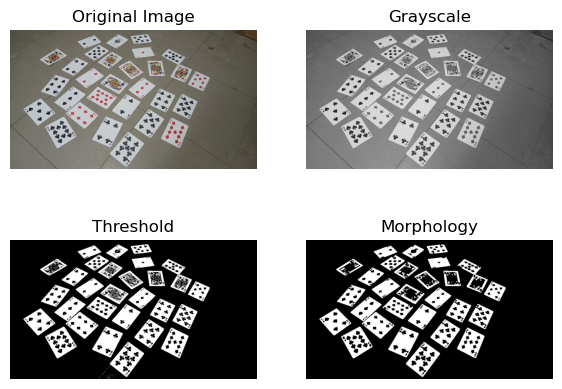

In [11]:
plt.figure(figsize=(7, 5))

plt.subplot(2, 2, 1)
plt.axis('off')
plt.title("Original Image")
plt.imshow(inputImageRGB)

plt.subplot(2, 2, 2)
plt.axis('off')
plt.title("Grayscale")
plt.imshow(imageGray, cmap='gray')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title("Threshold")
plt.imshow(thresholdImage, cmap='gray')

plt.subplot(2, 2, 4)
plt.axis('off')
plt.title("Morphology")
plt.imshow(morphImage, cmap='gray')
plt.show()

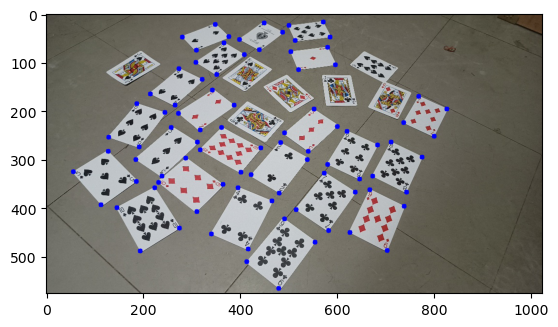

In [12]:
inputImageForMark = inputImageRGB.copy()
for corner in cardCorners:
    for point in corner:
        cv2.circle(inputImageForMark, tuple(point), 5, (0, 0, 255), -1)
    
plt.imshow(inputImageForMark)
plt.show()

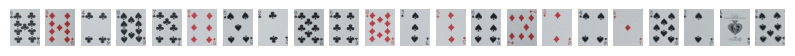

In [15]:
plt.figure(figsize=(10, 20))
for i in range(len(cardResult)):
    plt.subplot(1, len(cardResult), i+1)
    plt.axis('off')
    plt.imshow(cardResult[i])

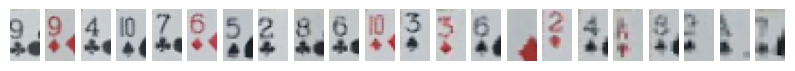

In [16]:
plt.figure(figsize=(10, 20))
for i in range(len(cardSuits)):
    plt.subplot(1, len(cardSuits), i+1)
    plt.axis('off')
    plt.imshow(cardSuits[i])

In [ ]:
import os
import numpy as np

In [ ]:
names = os.listdir("bicyclecard/images/")

In [ ]:
# inputImage = cv2.imread("bicyclecard/images/"+np.random.choice(names))
inputImage = cv2.imread("bicyclecard/images/IMG_20230520_185914631.jpg")
inputImageRGB = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
cardContours = get_card_contour(inputImageRGB)
cardResult = crop_cards(cardContours, inputImageRGB)
cardSuits = get_card_suits(cardResult)

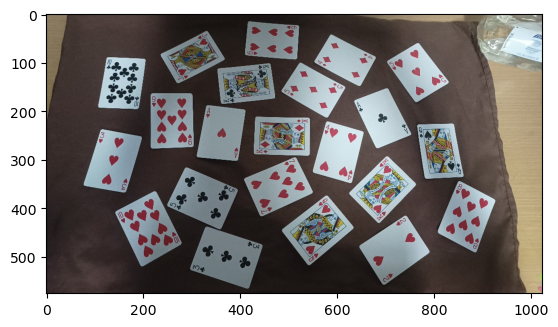

In [ ]:
plt.imshow(inputImageRGB)

In [ ]:
for i in range(len(cardResult)):
    plt.subplot(1, len(cardResult), i+1)
    plt.imshow(cardResult[i])

In [ ]:
for i in range(len(cardSuits)):
    plt.subplot(1, len(cardSuits), i+1)
    plt.imshow(cardSuits[i])

In [ ]:
import os

In [ ]:
img_path = "bicyclecard/images/"
names = os.listdir(img_path)

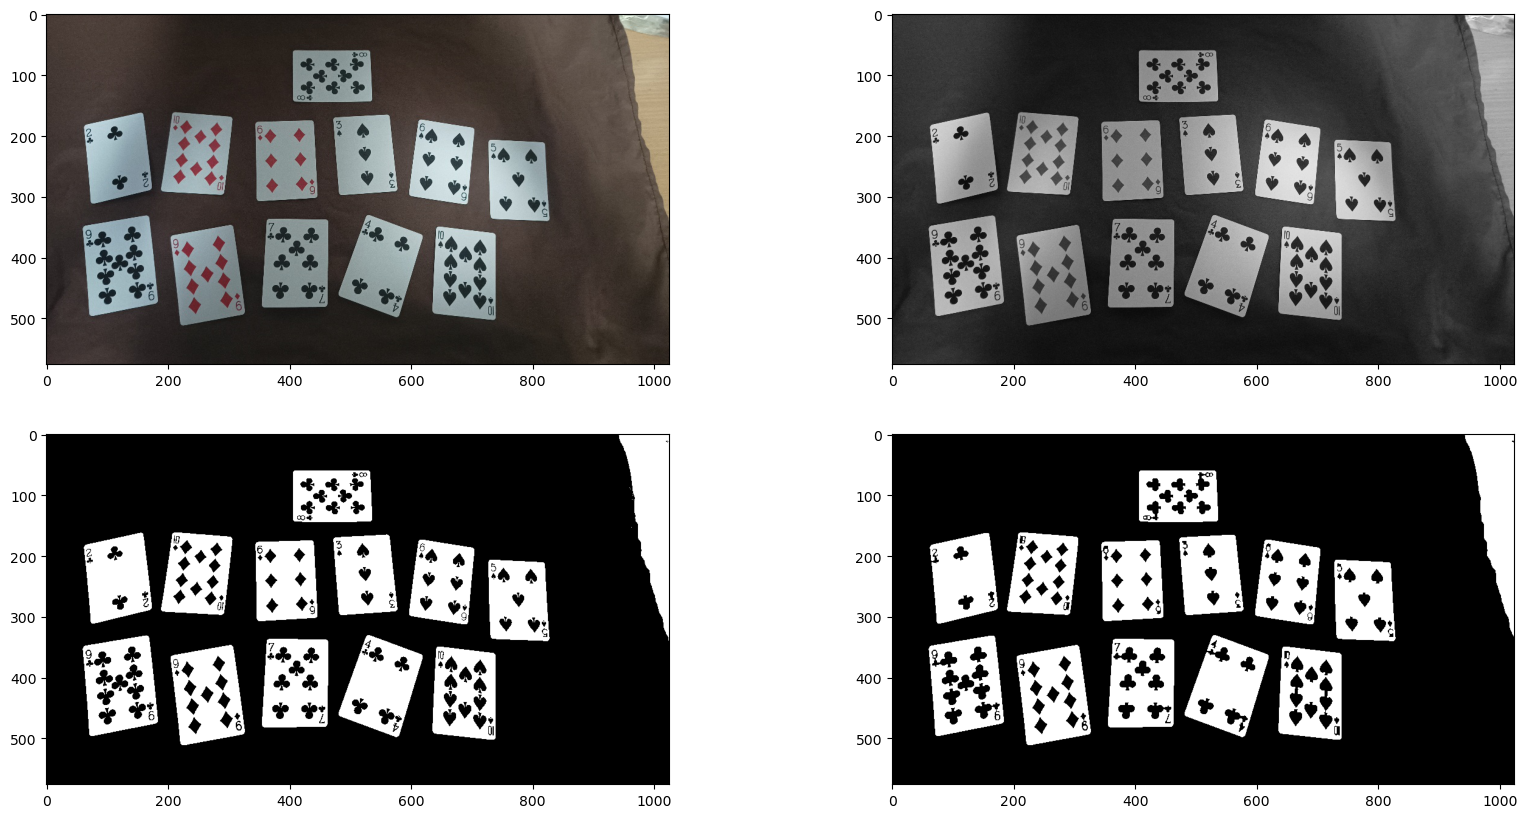

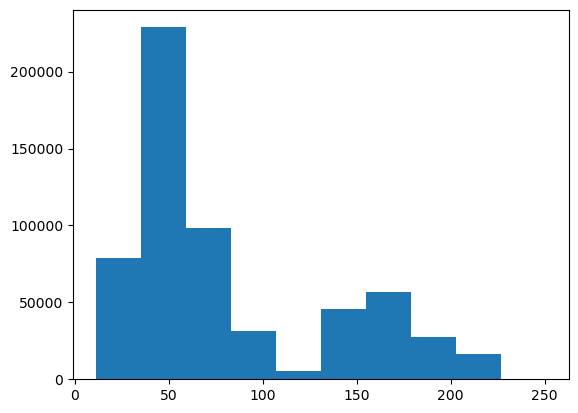

In [ ]:
# inputImage = get_sample_card()
# inputImage = cv2.cvtColor(cv2.imread("assets/cards01.jpg"), cv2.COLOR_BGR2RGB)
inputImage = cv2.cvtColor(cv2.imread(img_path+np.random.choice(names)), cv2.COLOR_BGR2RGB)

inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_RGB2GRAY)
# inputImageGray = cv2.medianBlur(inputImageGray, 13)
_,thresholdImage = cv2.threshold(inputImageGray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
morphImage = cv2.morphologyEx(thresholdImage, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
# morphImage = thresholdImage

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(inputImage)

plt.subplot(2, 2, 2)
plt.imshow(inputImageGray, cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(thresholdImage, cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(morphImage, cmap='gray')

plt.show()

plt.hist(inputImageGray.flatten())
plt.show()



contour points: [64, 152, 40, 139, 358, 52, 6, 75, 114, 77, 186, 101, 18, 151]
contour area:   [14282.0, 15579.5, 14929.0, 16356.5, 13913.0, 12125.5, 19.0, 12275.5, 11959.5, 11864.0, 12710.0, 13045.5, 10680.5, 14720.0]
contour points: [64, 152, 40, 139, 358, 52, 75, 114, 77, 186, 101, 18, 151]
contour area:   [14282.0, 15579.5, 14929.0, 16356.5, 13913.0, 12125.5, 12275.5, 11959.5, 11864.0, 12710.0, 13045.5, 10680.5, 14720.0]
Total Card: 13


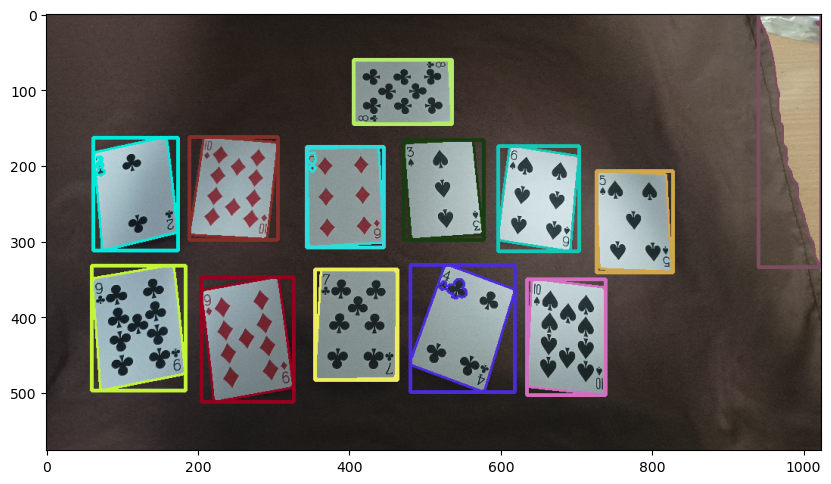

In [ ]:
cardContours, _ = cv2.findContours(morphImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('contour points:', [len(c) for c in cardContours] )
print('contour area:  ', [cv2.contourArea(c) for c in cardContours] )

cardContours = [ contour for contour in cardContours
                if len(contour) > 4 and
                len(contour) < 400 and
                cv2.contourArea(contour) > 1000 and
                cv2.contourArea(contour) < 20000]

print('contour points:', [len(c) for c in cardContours] )
print('contour area:  ', [cv2.contourArea(c) for c in cardContours] )

cardContourImage = inputImage.copy()
for cardContourIdx in range(len(cardContours)):
    # if cardContourIdx != 5:
    #     continue
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    
    x, y, w, h = cv2.boundingRect(cardContours[cardContourIdx])
    cv2.drawContours(cardContourImage, cardContours, cardContourIdx, color, 2)
    cv2.rectangle(cardContourImage,(x,y),(x+w,y+h),color,3)
cardContourImage = cv2.cvtColor(cardContourImage, cv2.COLOR_BGR2RGB)

print('Total Card:', len(cardContours))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cardContourImage, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
for cardContourIdx in range(len(cardContours)):
    cardContourImage = inputImage.copy()
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    x, y, w, h = cv2.boundingRect(cardContours[cardContourIdx])
    cv2.drawContours(cardContourImage, cardContours, cardContourIdx, color, 2)
    cv2.rectangle(cardContourImage,(x,y),(x+w,y+h),color,3)
    
    # rect = cv2.minAreaRect(cardContours[cardContourIdx])
    # box = cv2.boxPoints(rect)
    # box = np.intp(box)
    # cv2.drawContours(cardContourImage,[box],0,(0,0,255),2)
    
    # print(cardContourIdx)
    # plt.imshow(cardContourImage)
    # plt.show()


In [ ]:
def euc(pt_1, pt_2):
    return np.sqrt( (pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2 )

In [ ]:
def crop_cards(cardContours):
    result = []
    for contour in cardContours:
        convex = cv2.convexHull(contour) # should be card contour
        eps = 0.1*cv2.arcLength(convex, True)
        approximate_hull = cv2.approxPolyDP(convex, eps, True)
        approximate_hull = np.reshape(approximate_hull, (4,2))

        point_A = approximate_hull[0]
        point_B = approximate_hull[3]
        point_C = approximate_hull[2]
        point_D = approximate_hull[1]

        AD = euc(point_A, point_D)
        BC = euc(point_B, point_C)
        AB = euc(point_A, point_B)
        CD = euc(point_C, point_D)

        maxWidth = max(int(AD), int(BC))
        maxHeight = max(int(AB), int(CD))

        input_points = np.float32([point_A,point_B,point_C,point_D])
        output_points = np.float32([(0,0), (0, maxHeight-1), (maxWidth-1, maxHeight-1), (maxWidth-1, 0)])

        transform = cv2.getPerspectiveTransform(input_points, output_points)
        output = cv2.warpPerspective(inputImage.copy(), transform, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

        # rotate card
        if output.shape[0] < output.shape[1]:
            output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
        result.append(output)

    return result

In [ ]:
res = crop_cards(cardContours)

ValueError: cannot reshape array of size 6 into shape (4,2)

In [ ]:
for i in range(len(res)):
    plt.subplot(1, len(res), i+1)
    plt.imshow(res[i])

NameError: name 'res' is not defined

In [ ]:
# crop card result to get suit and number
tmp = res[0].copy()
tmp = tmp[:tmp.shape[0]//4, :tmp.shape[1]//4]

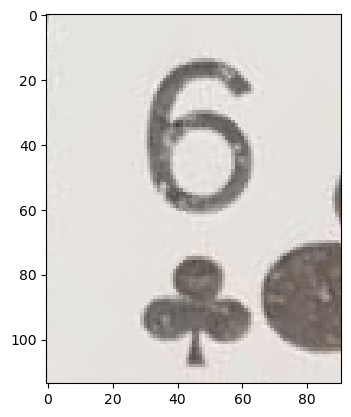

In [ ]:
plt.imshow(tmp)
plt.show()

In [ ]:
# inputImage = get_sample_card()
# inputImage = cv2.cvtColor(cv2.imread('kaggle_dataset/Images/Images/JD34.jpg'), cv2.COLOR_BGR2RGB)
# inputImage = cv2.cvtColor(cv2.imread('kaggle_dataset/Images/Images/5S39.jpg'), cv2.COLOR_BGR2RGB) #ภาพติดมุม
# inputImage = cv2.cvtColor(cv2.imread('kaggle_dataset/Images/Images/2S31.jpg'), cv2.COLOR_BGR2RGB) #ภาพติดมุม
inputImage = cv2.cvtColor(cv2.imread('kaggle_dataset/Images/Images/7S49.jpg'), cv2.COLOR_BGR2RGB) #ได้ลายแทนทั้งการ์ด

inputImage = cv2.resize(inputImage, None, fx=0.3, fy=0.3)
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
def cv2Canny(threshold1, threshold2):
    cannyImage = cv2.Canny(inputImage,threshold1,threshold2)
    plt.figure(figsize=(7,7))
    plt.imshow(cannyImage, cmap='gray')
    plt.show()
interact(cv2Canny, 
         threshold1=widgets.IntSlider(min=1,max=1000,step=2,value=100), 
         threshold2=widgets.IntSlider(min=1,max=1200,step=2,value=200));

interactive(children=(IntSlider(value=100, description='threshold1', max=1000, min=1, step=2), IntSlider(value…

In [ ]:
# inputImage = get_sample_card()
# inputImage = cv2.cvtColor(cv2.imread('kaggle_dataset/Images/Images/AC37.jpg'), cv2.COLOR_BGR2RGB)

def cardDetection():
    # inputImage = get_sample_card()
    inputImage = cv2.cvtColor(cv2.imread("tmp.jpg"), cv2.COLOR_BGR2RGB)
    inputImage = cv2.resize(inputImage, None, fx=0.3, fy=0.3)
    inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
    output = cv2.Canny(inputImageGray, threshold1=100, threshold2=200)
    output = cv2.dilate(output, np.ones((3,3)), iterations=1)
    cardContours, _ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cardContours = sorted(cardContours, key=lambda x: cv2.contourArea(x), reverse=True)
    print(f'Find {len(cardContours)} contours')

    convex = cv2.convexHull(cardContours[0]) # should be card contour
    cardContourImage = inputImage.copy()
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(cardContourImage, [convex], 0, color, 8)
    plt.figure(figsize=(15,10))
    plt.subplot(131)
    plt.imshow(cardContourImage, cmap='gray')
    # plt.show()

    eps = 0.1*cv2.arcLength(convex, True)
    approximate_hull = cv2.approxPolyDP(convex, eps, True)
    approximate_hull = np.reshape(approximate_hull, (4,2))

    cardContourImage_Approx = cardContourImage.copy()
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(cardContourImage_Approx, [approximate_hull], -1, color, 3)
    plt.subplot(132)
    plt.imshow(cardContourImage_Approx,cmap='gray')
    # plt.show()

    point_A = approximate_hull[3]
    point_B = approximate_hull[2]
    point_C = approximate_hull[1]
    point_D = approximate_hull[0]

    def euc(pt_1, pt_2):
        return np.sqrt( (pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2 )

    AD = euc(point_A, point_D)
    BC = euc(point_B, point_C)
    AB = euc(point_A, point_B)
    CD = euc(point_C, point_D)

    maxWidth = max(int(AD), int(BC))
    maxHeight = max(int(AB), int(CD))

    input_points = np.float32([point_A,point_B,point_C,point_D])
    output_points = np.float32([(0,0), (0, maxHeight-1), (maxWidth-1, maxHeight-1), (maxWidth-1, 0)])

    transform = cv2.getPerspectiveTransform(input_points, output_points)
    output = cv2.warpPerspective(inputImage.copy(), transform, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

    # # Resize to Mask size
    # output_5 = cv2.resize(output_5, (maskImage.shape[1], maskImage.shape[0]), interpolation = cv2.INTER_AREA)

    # Debug output
    print("output")
    plt.subplot(133)
    plt.imshow(output,cmap='gray')
    plt.show()


Find 3 contours
output


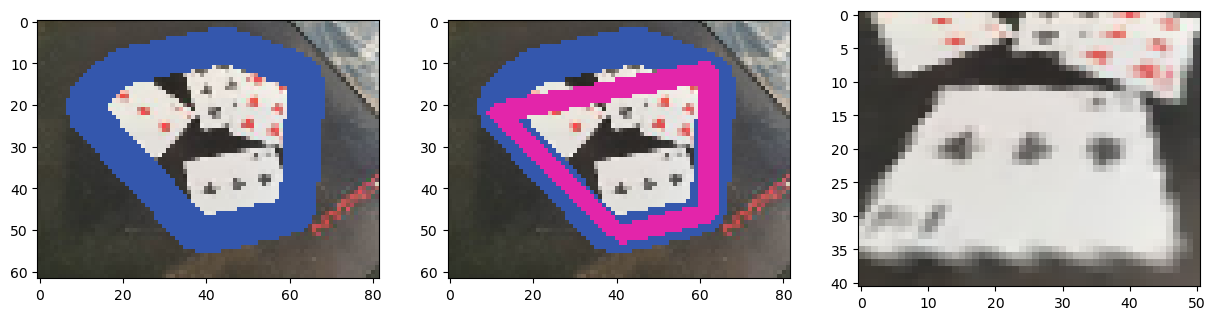

In [ ]:
cardDetection()